In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr

import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

%matplotlib widget
import matplotlib.pyplot as plt

save_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/")
datasets = Path("/work/pi_kandread_umass_edu/Datasets/")

fig_dir = save_dir / "figures"
fig_dir.mkdir(exist_ok=True)

polygons = gpd.read_file(save_dir/"metadata"/'site_basin_polygons.shp', engine="pyogrio", use_arrow=True)
polygons = polygons.set_index('wqp_id')

attributes = pd.read_csv(save_dir/"attributes"/"attributes.csv", index_col='index')

hybas = gpd.read_file(datasets / 'HydroBASINS/hybas_na_lev01-12_v1c/hybas_na_lev04_v1c.shp')
hybas = hybas.to_crs("EPSG:5070")

data = {}
nc_files = list((save_dir / "time_series").glob('*.nc'))
for f in tqdm(nc_files):
    with xr.open_dataset(f) as ds:
        means = ds.mean(dim='date')
        counts = ds.count(dim='date')
        # break
        
        # Combine metadata into a single dict
        combined_dict = {}
        for var in ds.variables:
            if var in means and var in counts:
                combined_dict[f"{var}_mean"] = means[var].values
                # combined_dict[f"{var}_count"] = counts[var].values
        for var in ['Red','ssc','turbidity','flux','usgs_q']:
            combined_dict[f"{var}_counts"] = ds[var].resample(date='YE').count().values
                
        data[f.stem] = combined_dict  
                              
nc_summary = pd.DataFrame.from_dict(data, orient='index')

metadata = polygons[['geometry']].join(attributes, how='inner').join(nc_summary,how='inner')

ignore_basins = ['USGS-09383100']
metadata = metadata.drop(ignore_basins)

file_path = save_dir/'metadata'/'site_lists'/'sites.txt'
metadata.reset_index()['index'].to_csv(file_path, header=False, index=False)

  0%|          | 0/741 [00:00<?, ?it/s]

In [2]:
split_idx = np.nonzero(np.arange(1980,2022)==2014)[0][0]

for idx, row in metadata.iterrows():
    for var in ['Red','ssc','turbidity','flux','usgs_q']:
        metadata.loc[idx,f'train_{var}'] = row[f'{var}_counts'][:split_idx].sum()
        metadata.loc[idx,f'test_{var}'] = row[f'{var}_counts'][split_idx:].sum()
    
metadata['train_sed'] = metadata['train_ssc'] + metadata['train_flux']
metadata['test_sed'] = metadata['test_ssc'] + metadata['test_flux']

metadata['no_sed'] = (metadata['train_sed'] == 0) & (metadata['test_sed'] == 0)
metadata['train_only'] = (metadata['train_sed'] > 0) & (metadata['test_sed'] == 0)
metadata['test_only'] = (metadata['test_sed'] > 0) & (metadata['train_sed'] == 0)

metadata['train_test_ratio'] = metadata['train_sed'] / metadata['test_sed'] 

print("Basin Counts")
print(f"total basins: {len(metadata)}")
print(f"no sed data: {metadata['no_sed'].sum()}")
print(f"train only: {metadata['train_only'].sum()}")
print(f"test only: {metadata['test_only'].sum()}")

Basin Counts
total basins: 740
no sed data: 6
train only: 427
test only: 13


In [3]:
wqp_locs = gpd.read_file("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/metadata/wqp_sites.shp")
wqp_locs = wqp_locs.set_index('LocationID')
wqp_locs = wqp_locs.to_crs("EPSG:5070")
wqp_locs = wqp_locs.merge(metadata,right_index=True, left_index=True)
wqp_locs = wqp_locs.set_geometry('geometry_x')

for idx, row in metadata.iterrows():
    for feature in ['Red','ssc','flux','usgs_q']:
        wqp_locs.loc[idx,f'{feature}_total_count'] = np.sum(row[f'{feature}_counts'])

In [4]:
locs_with_basin = gpd.sjoin(wqp_locs, hybas[['HYBAS_ID','geometry']], how="left", predicate="within")
locs_with_basin['has_test'] = locs_with_basin['test_sed'] > 0
locs_with_basin['has_train'] = locs_with_basin['train_sed'] > 0

copy_cols = ['train_sed','test_sed', 'train_ssc', 'test_ssc', 'train_flux', 'test_flux', 'has_train', 'has_test']
basin_counts = locs_with_basin.groupby('HYBAS_ID')[copy_cols].sum().reset_index()
basin_counts['train_only'] = basin_counts['test_sed'] == 0
basin_counts['test_only'] = basin_counts['train_sed'] == 0

In [6]:
splitting_df = basin_counts.copy()

train_basins = splitting_df[splitting_df['train_only']]
splitting_df.drop(train_basins.index, inplace=True)
test_basins = splitting_df[splitting_df['test_only']]
splitting_df.drop(test_basins.index, inplace=True)

test_count = len(basin_counts)//5
while len(test_basins) < test_count:
    next_train_idx = splitting_df['has_train'].argmax()
    # next_train_idx = splitting_df['train_test_ratio'].argmax()
    next_train = splitting_df.iloc[next_train_idx].copy()
    train_basins = pd.concat([train_basins, next_train.to_frame().T])
    splitting_df.drop(next_train.name, inplace=True)
    
    next_test_idx = splitting_df['has_test'].argmax()
    # next_test_idx = splitting_df['train_test_ratio'].argmin()
    next_test = splitting_df.iloc[next_test_idx].copy()
    test_basins = pd.concat([test_basins, next_test.to_frame().T])
    splitting_df.drop(next_test.name, inplace=True)
    
if len(splitting_df)>0:
    train_basins = pd.concat([train_basins, splitting_df])
    
train = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(train_basins['HYBAS_ID'])]
test = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(test_basins['HYBAS_ID'])]

print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train_basins['train_sed'].sum().astype(int):,d}")
print(f"\tssc: {train_basins['train_ssc'].sum().astype(int):,d}")
print(f"\tflux: {train_basins['train_flux'].sum().astype(int):,d}")
print(f"test: {test_basins['test_sed'].sum().astype(int):,d}")
print(f"\tssc: {test_basins['test_ssc'].sum().astype(int):,d}")
print(f"\tflux: {test_basins['test_flux'].sum().astype(int):,d}")

train_file_path = save_dir/'metadata'/'site_lists'/'basin_split_train_sites.txt'
train.reset_index()['index'].to_csv(train_file_path, header=False, index=False)

test_file_path = save_dir/'metadata'/'site_lists'/'basinx_split_test_sites.txt'
test.reset_index()['index'].to_csv(test_file_path, header=False, index=False)

Basin Counts
train: 512
test: 228

Sample Counts
train: 149,896
	ssc: 100,983
	flux: 48,913
test: 25,932
	ssc: 16,562
	flux: 9,370


In [260]:
splitting_df = metadata[~metadata['no_sed']].copy()

train = splitting_df[splitting_df['train_only']]
splitting_df.drop(train.index, inplace=True)
test = splitting_df[splitting_df['test_only']]
splitting_df.drop(test.index, inplace=True)

test_count = len(metadata)//5
while len(test) < test_count:
    next_test_idx = splitting_df['test_sed'].argmax()
    next_test = splitting_df.iloc[next_test_idx].copy()
    test = pd.concat([test, next_test.to_frame().T])
    splitting_df.drop(next_test.name, inplace=True)
    
    next_train_idx = splitting_df['train_sed'].argmax()
    next_train = splitting_df.iloc[next_train_idx].copy()
    train = pd.concat([train, next_train.to_frame().T])
    splitting_df.drop(next_train.name, inplace=True)
    
if len(splitting_df)>0:
    train = pd.concat([train, splitting_df])


print("\nSample Counts")
print(f"train: {train['train_sed'].sum().astype(int)}")
print(f"\tssc: {train['train_ssc'].sum().astype(int)}")
print(f"\tflux: {train['train_flux'].sum().astype(int)}")
print(f"test: {test['test_sed'].sum().astype(int)}")
print(f"\tssc: {test['test_ssc'].sum().astype(int)}")
print(f"\tflux: {test['test_flux'].sum().astype(int)}")

train_file_path = save_dir/'metadata'/'site_lists'/'fixed_better_train_sites.txt'
train.reset_index()['index'].to_csv(train_file_path, header=False, index=False)

test_file_path = save_dir/'metadata'/'site_lists'/'fixed_better_test_sites.txt'
test.reset_index()['index'].to_csv(test_file_path, header=False, index=False)


Sample Counts
train: 149174
	ssc: 100663
	flux: 48511
test: 35316
	ssc: 25346
	flux: 9970


In [16]:
import random

train_file_path = save_dir/'metadata'/'site_lists'/'better_train_sites.txt'
sites = pd.read_csv(train_file_path,header=None)[0].values

output_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/metadata/site_lists/k_folds")
num_folds = 4

# Shuffle the sites randomly
random.shuffle(sites)

# Calculate the size of each fold
fold_size = len(sites) // num_folds

# Create the output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Split the sites into folds and create train/test files
for i in range(num_folds):
    # Define the test set for this fold
    test_start = i * fold_size
    test_end = (i + 1) * fold_size if i < num_folds - 1 else len(sites)
    test_sites = sites[test_start:test_end]

    # Define the train set (all sites not in the test set)
    train_sites = [site for site in sites if site not in test_sites]

    # Write train file
    train_filename = f"train_{i}.txt"
    with open(output_dir / train_filename, 'w') as f:
        f.write('\n'.join(train_sites))

    # Write test file
    test_filename = f"test_{i}.txt"
    with open(output_dir / test_filename, 'w') as f:
        f.write('\n'.join(test_sites))

In [ ]:
metadata['test_flux_count'] = 0
for idx, row in train.iterrows():
    metadata.loc[idx,'test_flux_count'] = row['ssc_counts'][-8:].sum()

In [ ]:
test_file_path = save_dir/'metadata'/'site_lists'/'test_sites_8020.txt'
# Read the file into a list
with test_file_path.open('r') as file:
    site_list = file.read().splitlines()

test_counts = metadata.loc[site_list,'test_flux_count'].sort_values(ascending=False)

test_counts[0:10] 

In [47]:
np.NaN

nan

In [7]:
features = ['Red', 'ssc','flux','usgs_q', 'sed']

for feature in features:
    wqp_locs[f'split_train_{feature}'] = np.nan
    wqp_locs[f'split_test_{feature}'] = np.nan

for idx, row in train.iterrows():
    for feature in features:
        wqp_locs.loc[idx,f'split_train_{feature}'] = row[f'train_{feature}']
        
for idx, row in test.iterrows():
    for feature in features:
        wqp_locs.loc[idx,f'split_test_{feature}'] = row[f'test_{feature}']

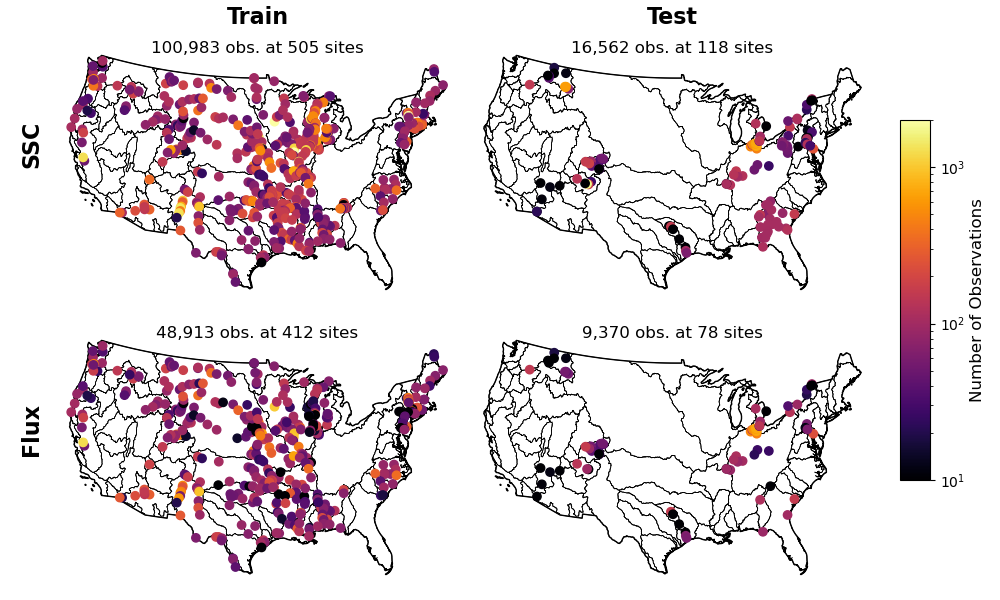

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import product
import numpy as np

outlines = gpd.read_file(datasets / 'Mapping/US_outlines/Contiguous_cb_2018_us_nation_20m/cb_2018_us_nation_20m.shp')
outlines = outlines.to_crs("EPSG:5070")

# Perform the clipping operation
clipped_hybas = gpd.clip(hybas, outlines)

norm = LogNorm(vmin=1E1, vmax=2E3)

def make_count_plot(ax, feature, subset):
    outlines.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
    clipped_hybas.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    
    col = f"split_{subset.lower()}_{feature.lower()}"
    n_sites = np.sum(wqp_locs[col] > 0)
    wqp_locs.plot(col, ax=ax, cmap='inferno', norm=norm)
    
    
    ax.set_title(f"{int(wqp_locs[col].sum()):,d} obs. at {n_sites} sites", y=0.93)
    ax.set_axis_off()
  
    return ax

features = ['SSC', 'Flux']
subsets = ['Train', 'Test']

n_rows = len(features)
n_cols = len(subsets)

plt.close('all')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))

for (i, feature), (j, subset) in product(enumerate(features), enumerate(subsets)):
    make_count_plot(axes[i, j], feature, subset)
    
right = 0.88
top = 0.95
bottom = 0
left = 0.05
wspace = 0
hspace = 0
fig.subplots_adjust(right=right, top=top, bottom=bottom, left=left, wspace=wspace, hspace=hspace)


# Calculate the width and height of each subplot
subplot_width = (right - left) / n_cols
subplot_height = (top - bottom) / n_rows 


# Add column labels (subsets)
for j, subset in enumerate(subsets):
    x = left + (j + 0.5) * subplot_width
    fig.text(x, 0.97, subset, ha='center', va='center', fontsize=16, fontweight='bold')

# Add row labels (features)
for i, feature in enumerate(features):
    y = top - (i + 0.4) * subplot_height
    fig.text(0.02, y, feature, rotation=90, va='center', fontsize=16, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
# sm._A = []  # Empty array for the scalar mappable
cbar_ax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Number of Observations', fontsize=12)

plt.show()

fig.savefig(fig_dir / "basin_split_train_test.png",  dpi=300)

In [148]:
get_subplot_center(0, 0)

(0.25, 0.7124999999999999)

In [70]:
ax.flatten()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

In [ ]:
list(metadata)

KeyError: 'turbidity_count'

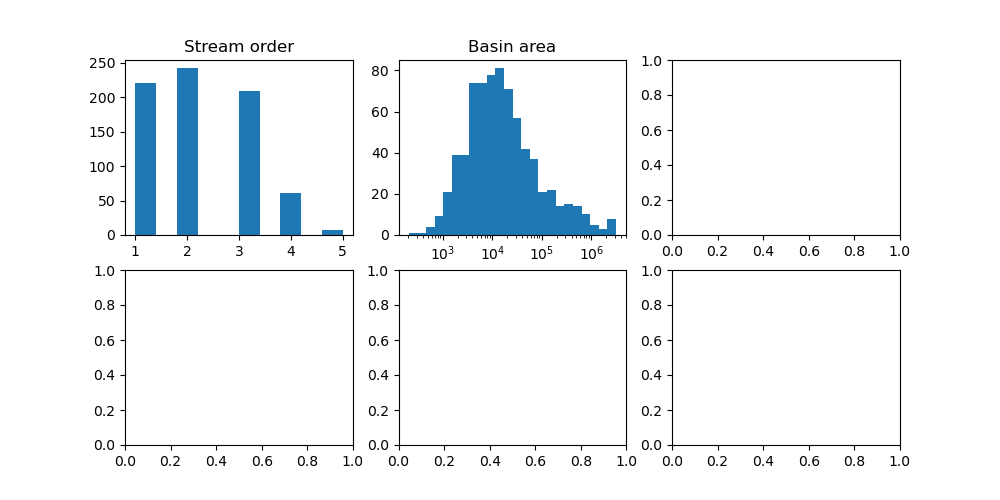

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

axes[0,0].hist(metadata["order"])
axes[0,0].set_title("Stream order")

bins = np.logspace(np.log10(min(metadata["area"])),np.log10(max(metadata["area"])), 25)
axes[0,1].hist(metadata["area"], bins=bins)
axes[0,1].set_xscale("log")
axes[0,1].set_title("Basin area")

targets = ["turbidity","ssc","flux"]
for i, target in enumerate(targets):
    bins = np.logspace(0,np.log10(max(metadata[f"{target}_count"])), 25)
    axes[1,i].hist(metadata[f"{target}_count"],bins=bins)
    axes[1,i].set_xscale("log")
    axes[1,i].set_title(f"Number of {target} measurements")


plt.tight_layout()
plt.show()


In [ ]:
list(metadata)

In [ ]:
area = 10000 #km^2
feature = "ssc"
n_sat_obs = 50

mask = ((metadata["area"]>=area) & 
        (metadata[f"n_red_{feature}"]>= n_sat_obs))

print(np.sum(mask))
file_name = f"sites_{feature}_area{area}_n{n_sat_obs}.txt"
file_path = save_dir/"site_lists"/file_name
print(file_path)

# Save the Series to a text file with no delimiters or headers
# metadata.hybas[mask].to_csv(file_path, header=False, index=False)

metadata[mask].plot(alpha=0.2)



In [ ]:
pwd